In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [82]:
df = pd.read_csv('C:/Users/zt/python_projects/ml/xgboost/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


- Outliers Analysis

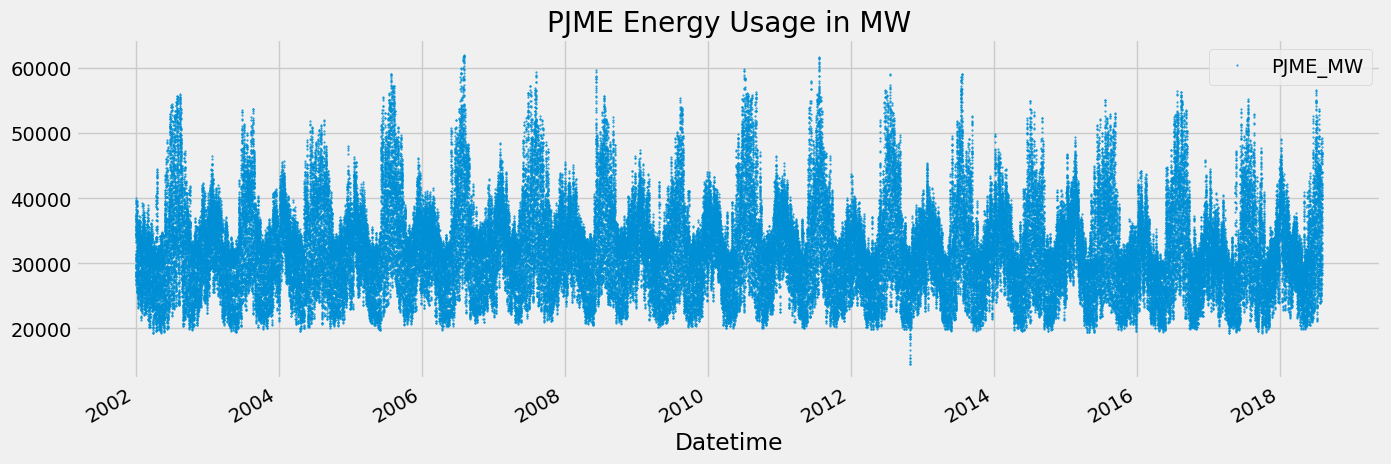

In [83]:
# outlier analysis
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0],
        ms=1,
        lw=1,
        title='PJME Energy Usage in MW')
plt.show()

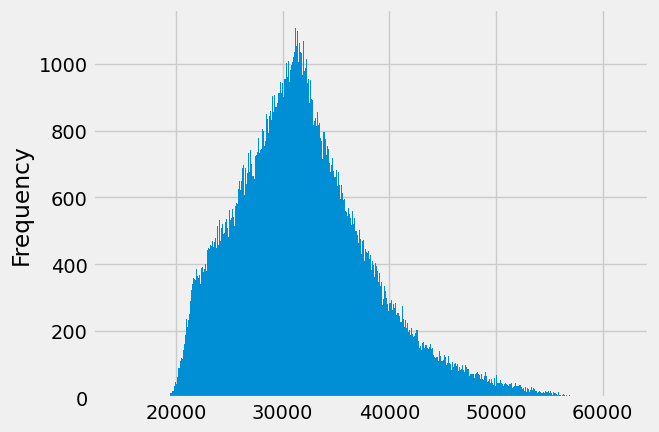

In [84]:
# most data are above 20_000, which means below 20_000 could be the outliers
df['PJME_MW'].plot(kind='hist', bins=500)
plt.show()

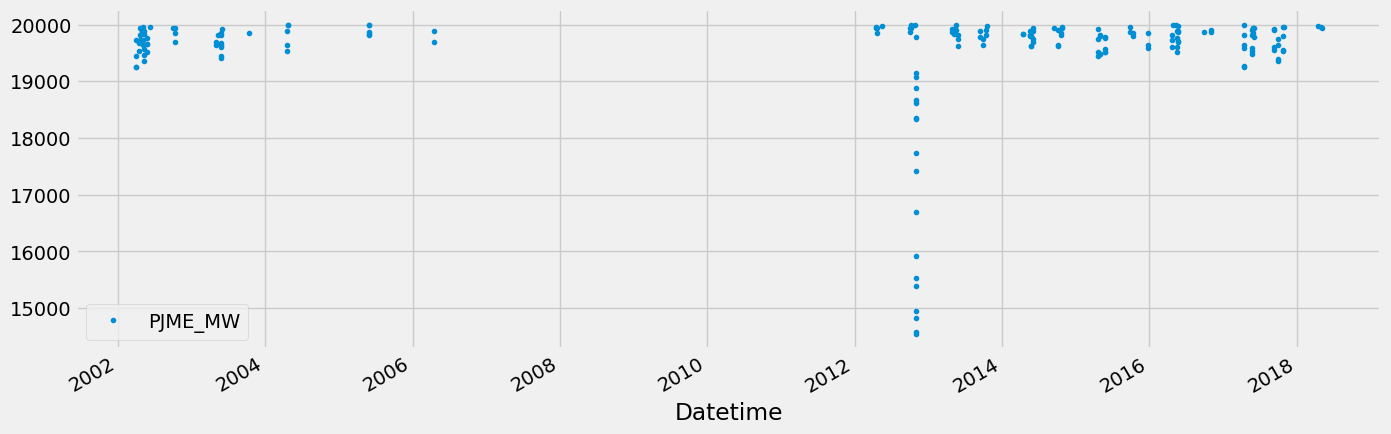

In [85]:
df.query('PJME_MW<20_000').plot(figsize=(15, 5), style='.')
plt.show()
# some outliers below 20_000

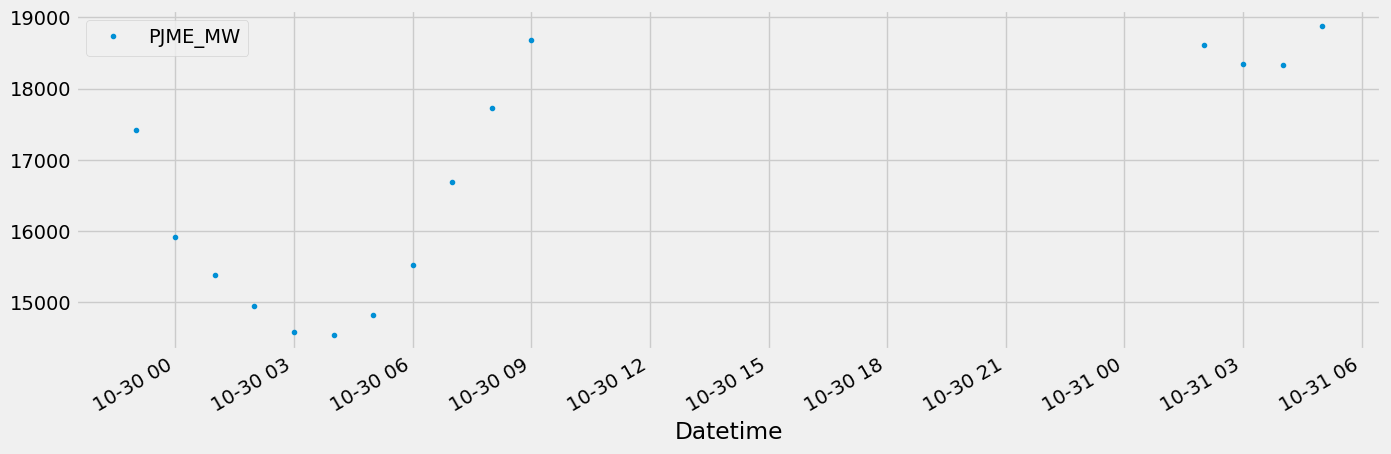

In [86]:
# below 19_000
df.query('PJME_MW<19_000').plot(figsize=(15, 5), style='.')
plt.show()

In [87]:
# remove the outliers
df = df.query('PJME_MW>19_000')

- Time Series Cross Validation

In [88]:
from sklearn.model_selection import TimeSeriesSplit

In [89]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
# we must sort the dataframe by index (Datetime), otherwise TimeSeriesSplit will not work
df = df.sort_index()
df.head(10)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
2002-01-01 06:00:00,28654.0
2002-01-01 07:00:00,29308.0
2002-01-01 08:00:00,29595.0
2002-01-01 09:00:00,29943.0


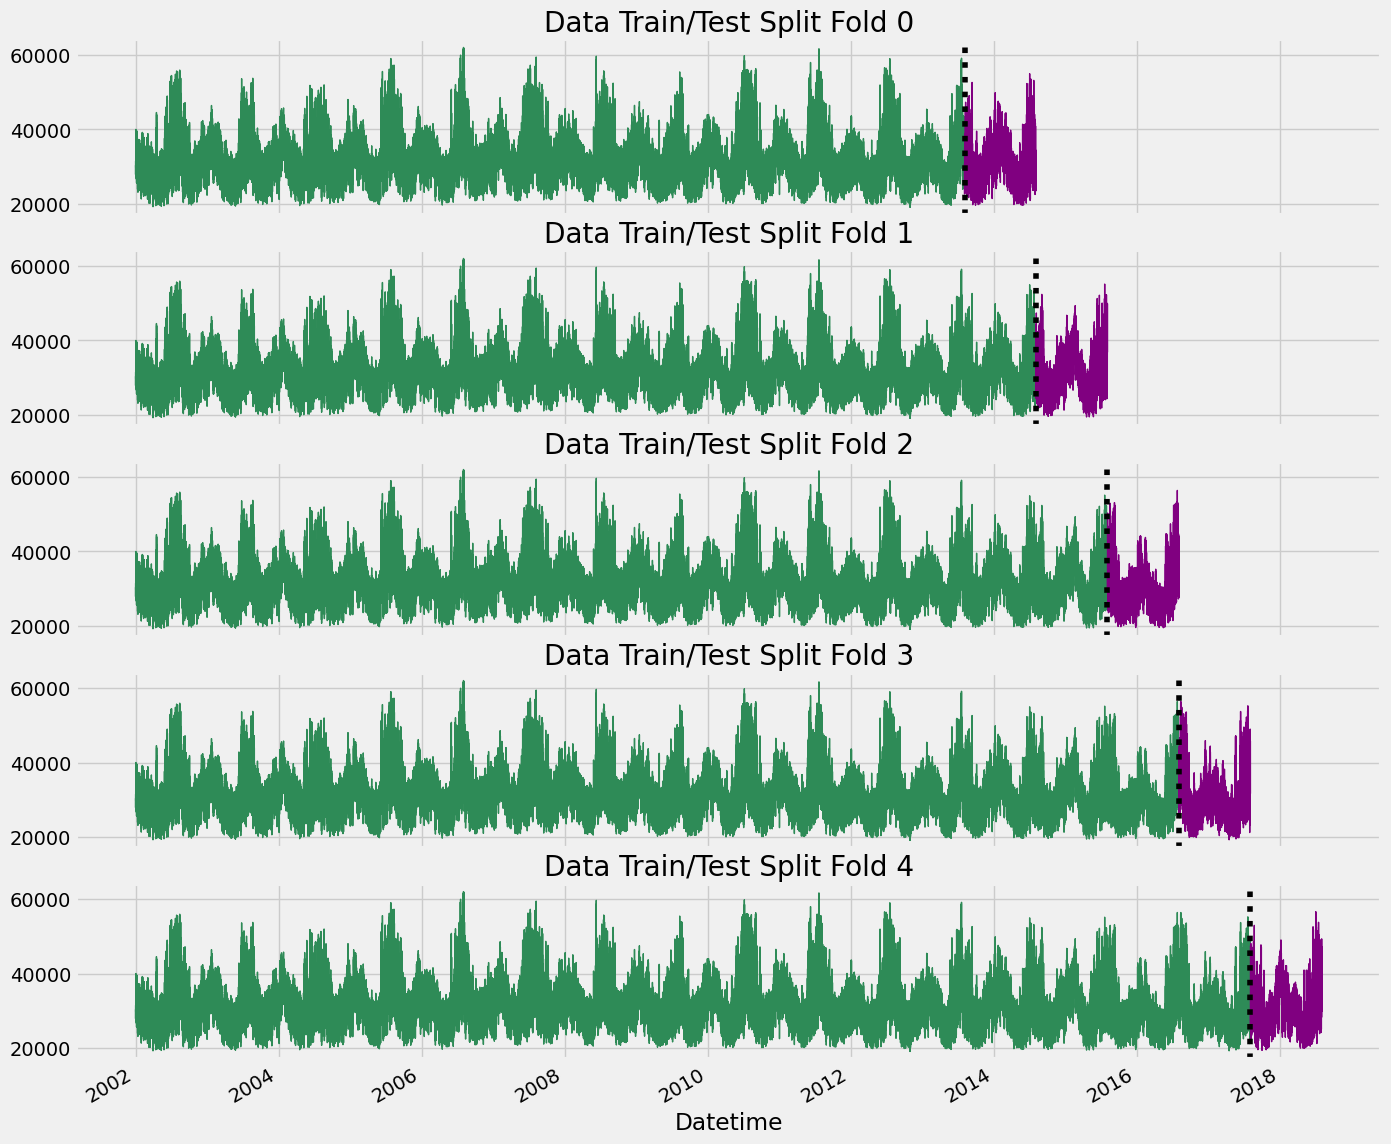

In [104]:
# cross validation with visualizations
fig, axs=plt.subplots(5, 1, 
                    figsize=(15,15),
                    sharex=True)

fold=0

for train_index, test_index in tss.split(df):
    train=df.iloc[train_index]  # store all training data to a variable called `train`
    test=df.iloc[test_index]  # store all test data to a variable called `test`
    
    # plot the training and test data 5 times (since n_split=5) and update the title with `fold`
    train['PJME_MW'].plot(ax=axs[fold],
                          ms=1,
                          lw=1,
                          color='seagreen',
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         ms=1,
                         lw=1,
                         color='purple',
                         label='Test set')
    
    axs[fold].axvline(test.index.min(), color='k', ls=':')  # draw a black dotted line on the begining date from the test set
    
    fold += 1  # +1 for each loop

plt.show()  

In [91]:
def create_features(df):
    '''
    Crate time series features based on time series index
    '''
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

- Lag Feature 

In [92]:
def shift_lags(df):
    df['lag1'] = df['PJME_MW'].shift(364)
    df['lag2'] = df['PJME_MW'].shift(728)
    df['lag3'] = df['PJME_MW'].shift(1092)
    return df

In [93]:
df = shift_lags(df)

In [94]:
df.head()
# no lag at the begining of the dataset since the lag cannot be computed

,PJME_MW,hour,dayofweek,dayofyear,quarter,month,year,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1,2002,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,1,2002,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,1,2002,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,1,2002,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,1,2002,NaN,NaN,NaN


In [95]:
df.tail()

,PJME_MW,hour,dayofweek,dayofyear,quarter,month,year,lag1,lag2,lag3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,214,3,8,2018,43742.0,51603.0,33723.0
2018-08-02 21:00:00,43256.0,21,3,214,3,8,2018,44607.0,53623.0,36543.0
2018-08-02 22:00:00,41552.0,22,3,214,3,8,2018,45057.0,54852.0,39402.0
2018-08-02 23:00:00,38500.0,23,3,214,3,8,2018,44294.0,54908.0,42429.0
2018-08-03 00:00:00,35486.0,0,4,215,3,8,2018,42401.0,54908.0,45148.0


In [96]:
print(f'Average fold score:{np.mean(scores):0.2f}')
print(f'Fold scores:{scores}')

Average fold score:3582.22
Fold scores:[3587.122338693311, 3266.216576344674, 3434.497700640123, 3785.189145094294, 3838.0527370668165]


- Train with lags

In [97]:
preds = []  # create an empty list `preds`
scores = []  # create an empty list `scores`

for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train = create_features(train) # add features to the training set
    test = create_features(test) # add features to the test set

    X_train = train[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1', 'lag2', 'lag3']]
    y_train = train['PJME_MW']

    X_test = test[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1', 'lag2', 'lag3']]
    y_test = test['PJME_MW']

    reg = xgb.XGBRegressor(base_score=0.5, 
                           booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=100,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.02,
                           reg_alpha=0,
                           reg_lambda=1,
                           subsample=0.55,
                           colsample_bytree=0.55)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)  # append the prediction to `preds`
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)  # append the scores to `score`

[0]	validation_0-rmse:32409.47688	validation_1-rmse:31638.62890
[100]	validation_0-rmse:5692.59017	validation_1-rmse:5322.93103
[200]	validation_0-rmse:3304.53259	validation_1-rmse:3649.41831
[300]	validation_0-rmse:3075.64405	validation_1-rmse:3607.24230
[400]	validation_0-rmse:2974.24793	validation_1-rmse:3593.18068
[488]	validation_0-rmse:2911.53425	validation_1-rmse:3593.85421
[0]	validation_0-rmse:32349.67077	validation_1-rmse:31820.87460
[100]	validation_0-rmse:5690.16559	validation_1-rmse:5467.63343
[200]	validation_0-rmse:3340.49088	validation_1-rmse:3577.70949
[300]	validation_0-rmse:3107.79379	validation_1-rmse:3434.01202
[400]	validation_0-rmse:3011.05259	validation_1-rmse:3368.92205
[500]	validation_0-rmse:2940.14589	validation_1-rmse:3330.10593
[600]	validation_0-rmse:2889.13661	validation_1-rmse:3303.09544
[700]	validation_0-rmse:2840.97886	validation_1-rmse:3280.54574
[800]	validation_0-rmse:2807.58150	validation_1-rmse:3276.42177
[900]	validation_0-rmse:2774.70844	valid

In [98]:
print(f'Average fold score: {np.mean(scores):0.2f}')
print(f'Fold scores: {scores}')

Average fold score: 3582.22
Fold scores: [3587.122338693311, 3266.216576344674, 3434.497700640123, 3785.189145094294, 3838.0527370668165]


- Predicting the Future

In [99]:
# train the model one last time using all data
X_all = df[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']]
y_all = df['PJME_MW']

reg = xgb.XGBRegressor(base_score=0.5, 
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=100,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.02,
                       reg_alpha=0,
                       reg_lambda=1,
                       subsample=0.55,
                       colsample_bytree=0.55)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32084.22680
[100]	validation_0-rmse:5769.32341
[200]	validation_0-rmse:3464.38527
[300]	validation_0-rmse:3231.23924
[400]	validation_0-rmse:3142.23280
[500]	validation_0-rmse:3079.45835
[600]	validation_0-rmse:3026.90462
[700]	validation_0-rmse:2987.10526
[800]	validation_0-rmse:2952.71633
[900]	validation_0-rmse:2925.68493
[999]	validation_0-rmse:2901.70308


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.55, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [100]:
# know the last timestamp for the dataframe
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [101]:
# create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = shift_lags(df_and_future)

In [102]:
future_w_features = df_and_future.query('isFuture')

C:\Users\zt\AppData\Local\Temp\ipykernel_7252\580541433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_w_features['pred'] = reg.predict(future_w_features[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']])


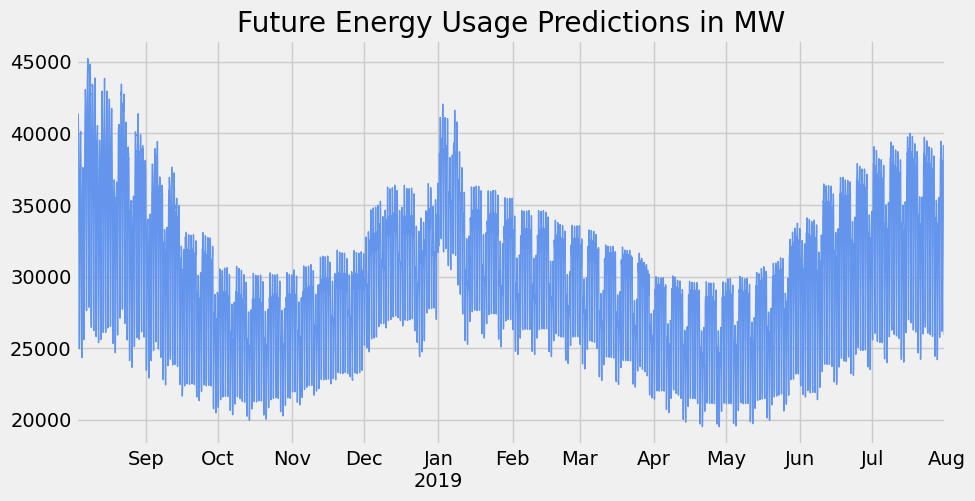

In [103]:
future_w_features['pred'] = reg.predict(future_w_features[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']])
future_w_features['pred'].plot(figsize=(10, 5),
                               color='cornflowerblue',
                               ms=1,
                               lw=1,
                               title='Future Energy Usage Predictions in MW')
plt.show()